# GRU Implementation

In [9]:
## Imports

import numpy as np  
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf 
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf # tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D,Activation,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Loading the Data

In [10]:
## Data Load

CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(".", topdown=False):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('\\')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('\\'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file), sep=',',header=None)
                list_of_img.append(df.values)

x = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

17485 files loaded.


# Example Person Sample

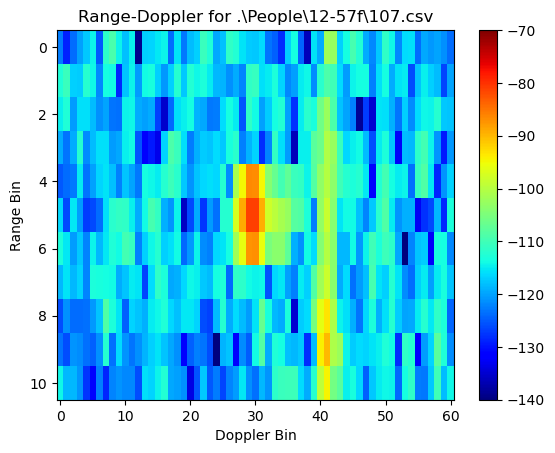

In [11]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[16300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[16299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Drone Sample

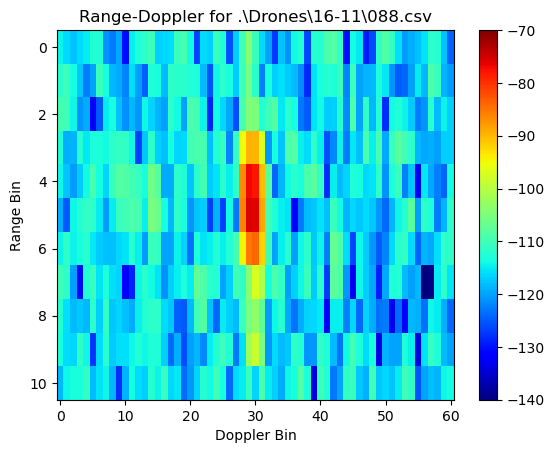

In [12]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[10300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[10299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Car Sample

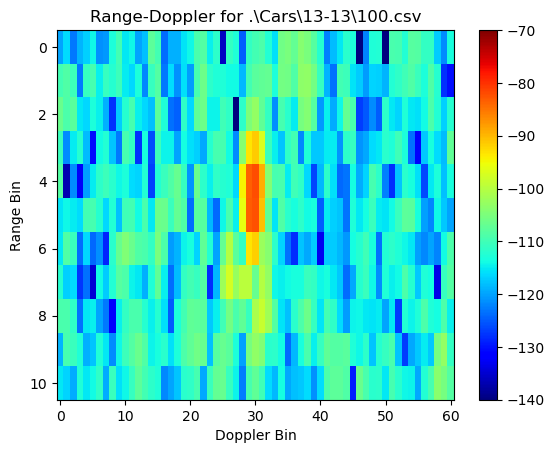

In [13]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[100], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[99]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Data Preprocessing

In [14]:
# Preprocessing the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train_original, x_test_original, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=62, shuffle=True)

x_train_original_shape = x_train_original.shape

# Reshape the data to 2D
x_train_reshaped = x_train_original.reshape(x_train_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)

# Reshape the data back to its original shape
x_train = x_train_scaled.reshape(x_train_original_shape)

# X_test scaling 
x_test_original_shape = x_test_original.shape

# Reshape the data to 2D
x_test_reshaped = x_test_original.reshape(x_test_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test_reshaped)

# Reshape the data back to its original shape
x_test = x_test_scaled.reshape(x_test_original_shape)

# Defining the Utility Functions to Plot Accuracies and Losses

In [15]:
##Defining utility functions to plot Accuracies and Losses

def smooth_curve(points,factor = 0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points

def plot_convergence():
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.plot(smooth_curve(history.history['accuracy']), marker= 'o', label = 'Train Accuracy')
  plt.plot(smooth_curve(history.history['val_accuracy']), marker= 'o', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(smooth_curve(history.history['loss']),marker = 'o', label = 'Train Loss')
  plt.plot(smooth_curve(history.history['val_loss']),marker = 'o', label = 'Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def test_model_accuracy(model):
  test_loss,test_accuracy = model.evaluate(x_test_gru, y_test_gru)
  print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
  plot_convergence()

# Reshaping the Data for Feeding the GRU

In [16]:
import numpy as np

def reshape_for_gru(X, y, time_steps):
    # Get the original shape
    samples, height, width = X.shape
    
    # Reshape X to (samples, time_steps, features)
    X_reshaped = X.reshape(samples, time_steps, height * width // time_steps)
    
    # Convert y to one-hot encoded format
    y_onehot = np.eye(np.max(y) + 1)[y]
    
    return X_reshaped, y_onehot

x_train_gru, y_train_gru = reshape_for_gru(x_train, y_train, time_steps=11)
x_test_gru, y_test_gru = reshape_for_gru(x_test, y_test, time_steps=11)

# GRU Model Building

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 11, 128)           73344     
                                                                 
 batch_normalization (BatchN  (None, 11, 128)          512       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 11, 128)           99072     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 128)          512       
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 5, 128)           0         
 ooling1D)                                                       
                                                        

In [18]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2,batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 32ms/step - loss: 0.6254 - accuracy: 0.7250 - val_loss: 0.9653 - val_accuracy: 0.6147
Epoch 2/30
175/175 [==============================] - 5s 27ms/step - loss: 0.4153 - accuracy: 0.8440 - val_loss: 0.3965 - val_accuracy: 0.8503
Epoch 3/30
175/175 [==============================] - 4s 26ms/step - loss: 0.3587 - accuracy: 0.8651 - val_loss: 0.2666 - val_accuracy: 0.8813
Epoch 4/30
175/175 [==============================] - 4s 25ms/step - loss: 0.3091 - accuracy: 0.8820 - val_loss: 0.2420 - val_accuracy: 0.9039
Epoch 5/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2814 - accuracy: 0.8926 - val_loss: 0.2111 - val_accuracy: 0.9146
Epoch 6/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2543 - accuracy: 0.9048 - val_loss: 0.2143 - val_accuracy: 0.9121
Epoch 7/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2383 - accuracy: 0.9124 - val_loss: 0.2107 - val_accuracy: 0.919

110/110 [==============================] - 1s 7ms/step - loss: 0.2551 - accuracy: 0.9405
Test Accuracy: 94.0520%


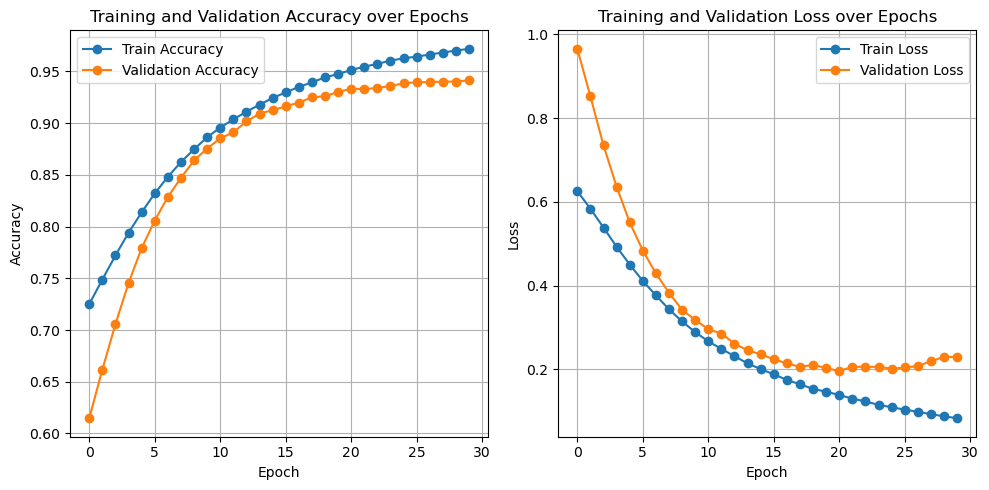

In [19]:
test_model_accuracy(model)

# Saving the Model

In [20]:
from tensorflow.keras.models import load_model

model.save('gru_model2')

INFO:tensorflow:Assets written to: gru_model2\assets


In [21]:
model2 = load_model('gru_model2')

# Classification Report

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(x_test_gru)
y_test_labels = np.argmax(y_test_gru, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Generating the classification report
print(classification_report(y_test_labels, y_pred))

110/110 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1160
           1       0.89      0.94      0.91      1001
           2       0.98      0.99      0.98      1336

    accuracy                           0.94      3497
   macro avg       0.94      0.94      0.94      3497
weighted avg       0.94      0.94      0.94      3497



# Confusion Matrix

In [23]:
labels = ['car', 'drone', 'people']

evaluation = model.evaluate(x_test_gru, y_test_gru)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

110/110 [==============================] - 1s 8ms/step - loss: 0.2551 - accuracy: 0.9405
Test Accuracy : 94.05%


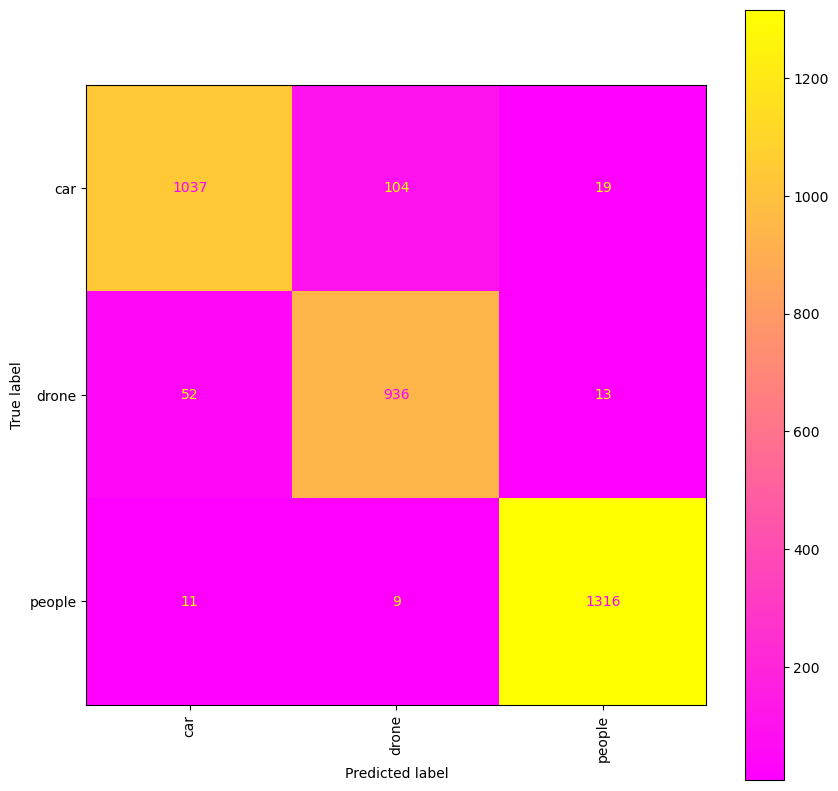

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='spring')

plt.show()